## Regresión del valor de valor medio de casas en distritos de California

Se requiere construir una regresión que nos permita predecir el valor de valor medio de casas en distritos de California, EEUU (medidos en ciento de miles de dólares $100.000).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.linear_model import LinearRegression, Ridge

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

sns.set()


## Dataset - California Housing

[dataset](https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset) **Scikit-Learn**.

Este dataset deriva del censo de 1990 de EEUU, donde cada observación es un bloque. Un bloque es la unidad geográfica más pequeña para la cual la Oficina del Censo de EEUU publica datos de muestra (un bloque típicamente tiene una población de 600 a 3.000 personas).

Un hogar es un grupo de personas que residen dentro de una casa. Dado que el número promedio de habitaciones y dormitorios en este conjunto de datos se proporciona por hogar, estas columnas pueden tomar valores grandes para grupos de bloques con pocos hogares y muchas casas vacías.

Los atributos, en el orden que se guardaron en el dataset son:

- `MedInc`: Ingreso medio en el bloque
- `HouseAge`: Edad mediana de las casas en el bloque
- `AveRooms`: Número promedio de habitaciones por hogar.
- `AveBedrms`: Número promedio de dormitorios por hogar.
- `Population`: Población del bloque
- `AveOccup`: Número promedio de miembros por hogar.
- `Latitude`: Latitud del bloque
- `Longitude`: Longitud del bloque

Y el target es:

`MedHouseVal`: Mediana del costo de casas en el bloque (en unidades de a $100.000)


In [ ]:
# Leemos el dataset
california_housing = fetch_california_housing()

# Y obtenemos los atributos y target
X = california_housing.data
y = california_housing.target

# Transformamos en Pandas
X = pd.DataFrame(X, columns=california_housing['feature_names'])
y = pd.Series(y, name=california_housing['target_names'][0])

# Unimos a X e y, esto ayuda a la parte de la gráfica del mapa de calor de correlación
df_california = pd.concat([X, y], axis=1)

In [ ]:
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

In [ ]:
df_california.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [ ]:
df_california.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


## 1 - Correlación entre atributos

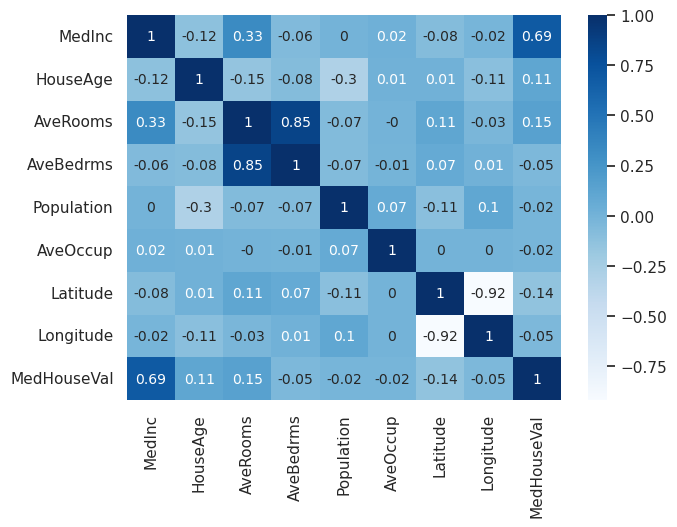

In [ ]:
plt.figure(figsize=(7, 5))
correlation = df_california.corr().round(2)
sns.heatmap(data=correlation, annot=True, annot_kws={"size": 10}, cmap='Blues')
plt.show()

El atributo `MedInc` (Ingreso medio en el bloque) es el que muestra una mayor correlación lineal con el target.


In [ ]:
correlation_with_target = correlation['MedHouseVal'].sort_values(ascending=False)
print(correlation_with_target)


MedHouseVal    1.00
MedInc         0.69
AveRooms       0.15
HouseAge       0.11
Population    -0.02
AveOccup      -0.02
AveBedrms     -0.05
Longitude     -0.05
Latitude      -0.14
Name: MedHouseVal, dtype: float64


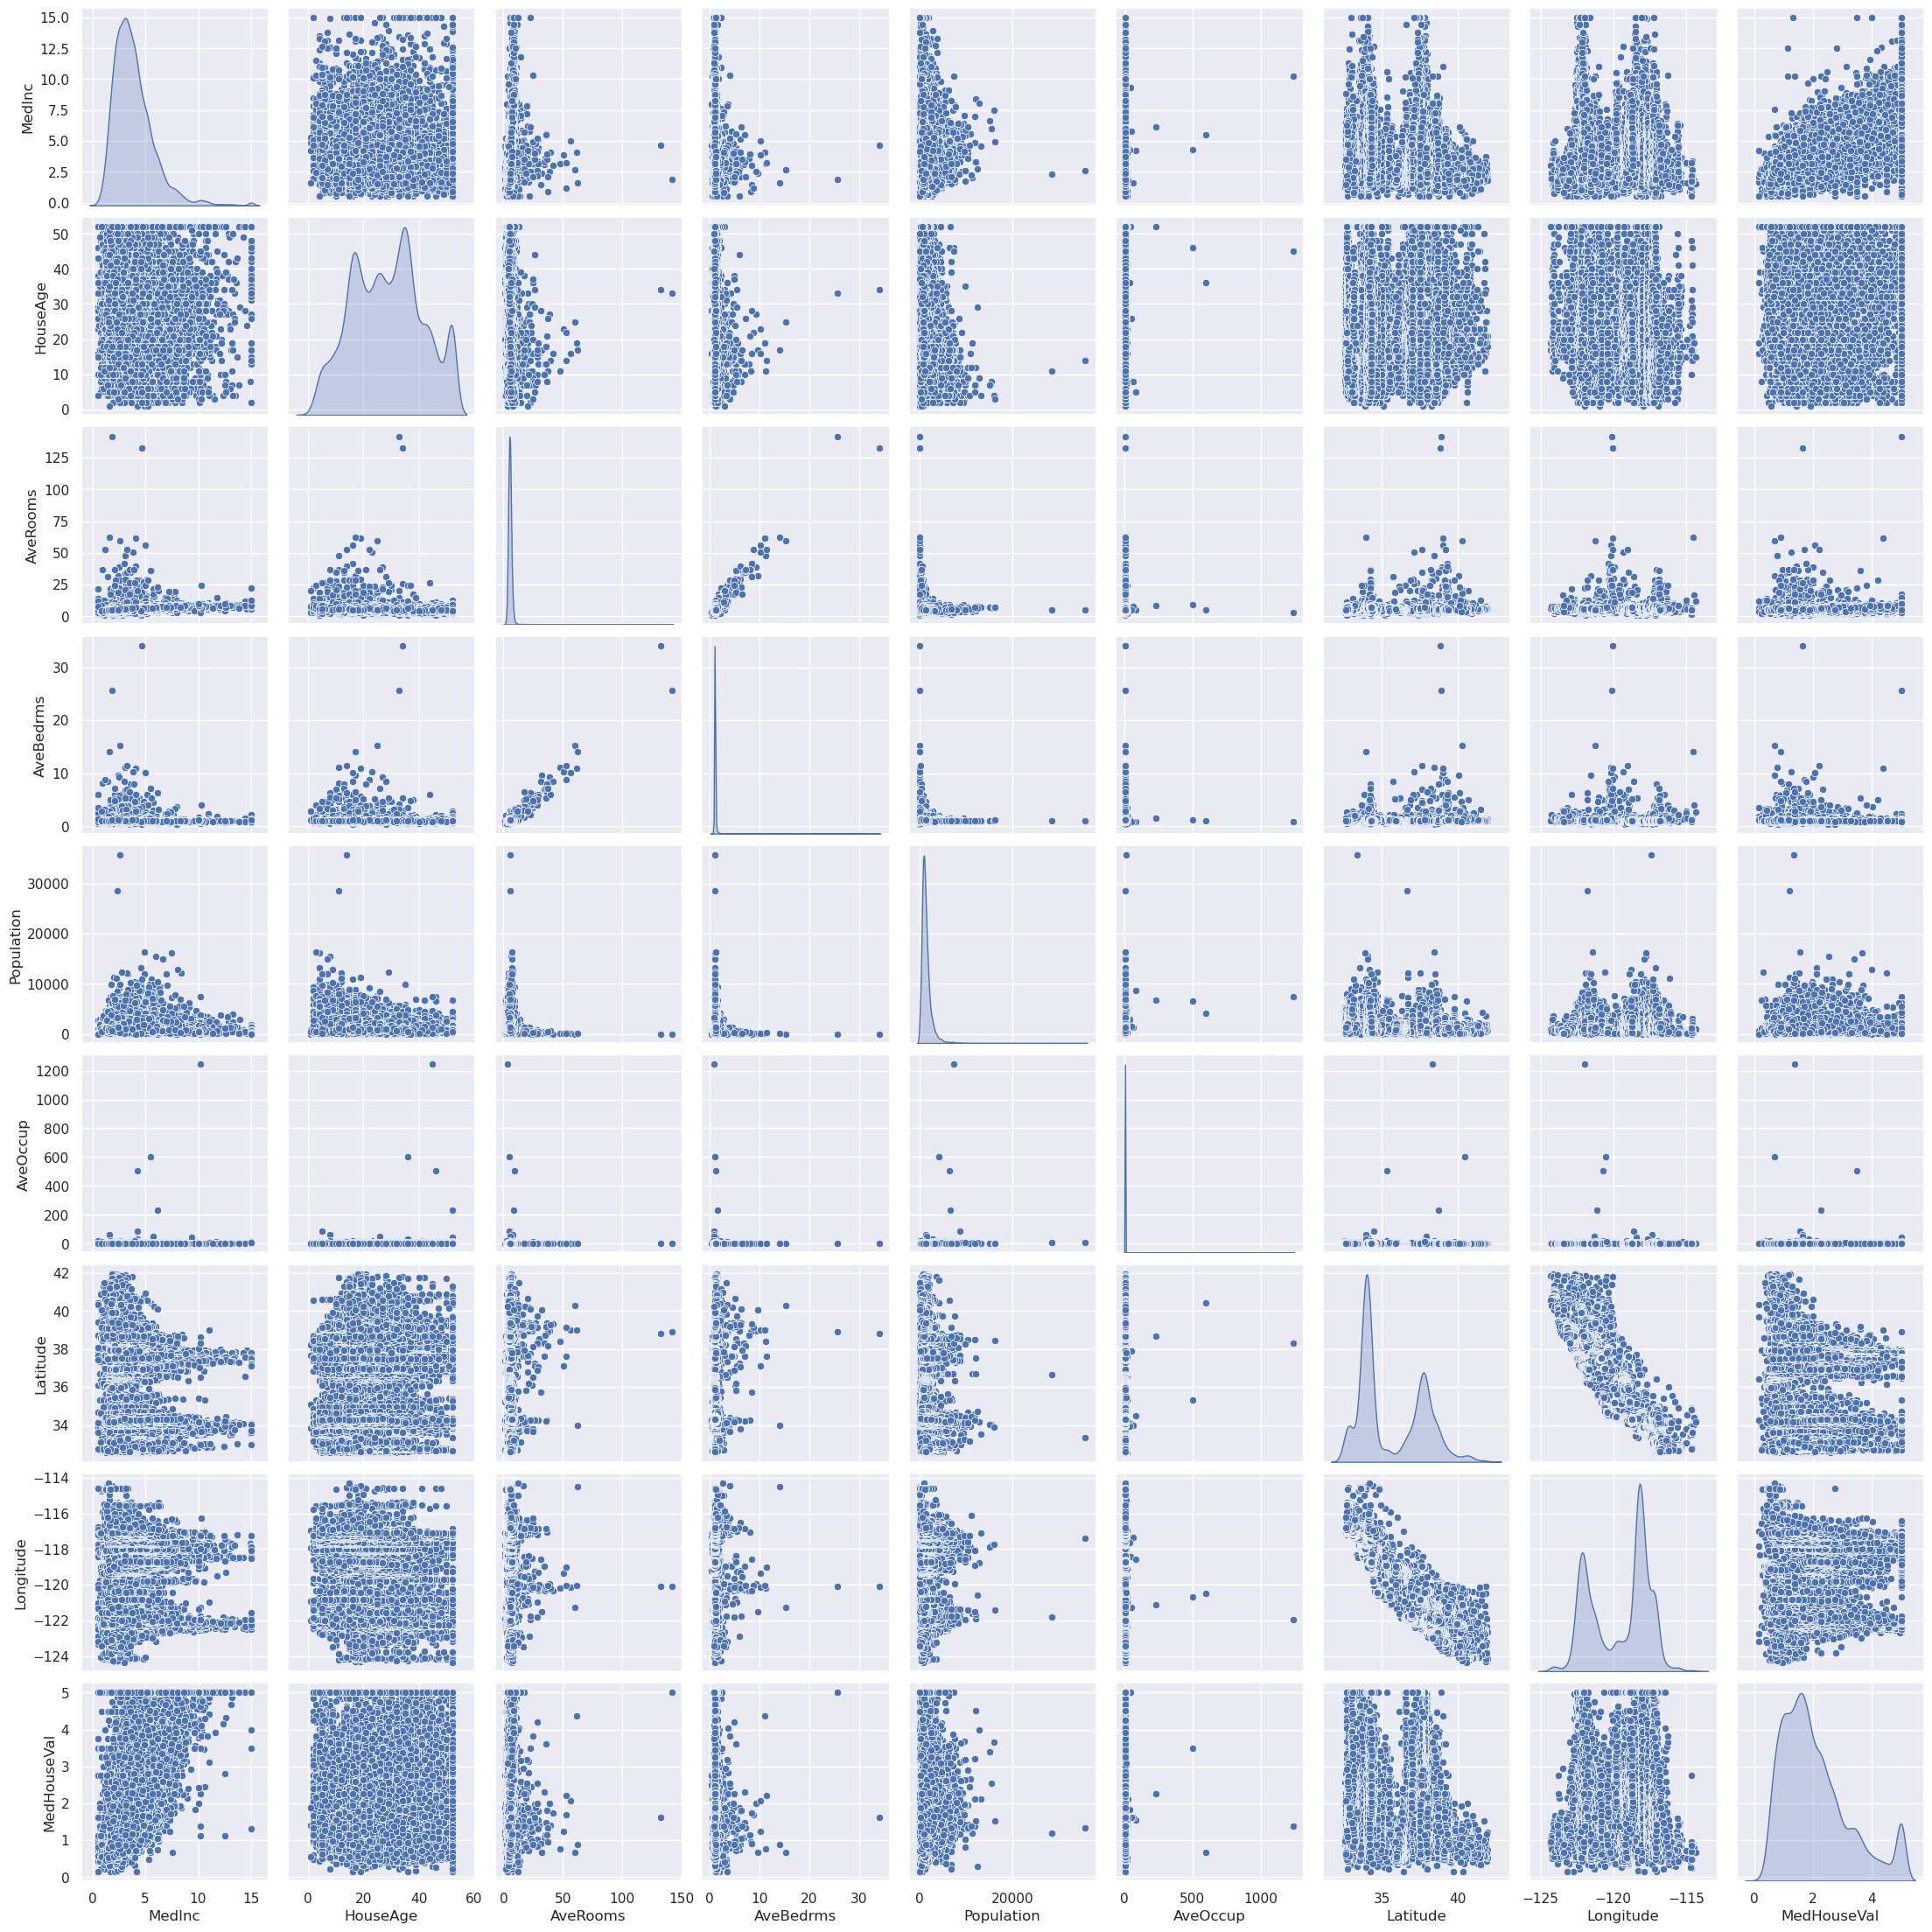

In [ ]:
sns.pairplot(data=df_california, diag_kind="kde");

Los atributos que tienen mayor correlación lineal entre sí son:

* `AveBedrms` y `AveRooms` \
   Número promedio de dormitorios por hogar / Número promedio de habitaciones por hogar \
   Correlación positiva 0.85
  
* `Longitude` y `Latitude` \
   Longitud del bloque / Latitud del bloque \
   Correlación negativa -0.92

  

In [ ]:
# Umbral asumido
threshold = 0.7

# Pares de atributos con correlación alta (> 0.7 o < -0.7)
high_correlation_pairs = (correlation.abs() > 0.7) & (correlation != 1.0)
high_correlation_attrs = correlation[high_correlation_pairs]

pairs = set()
for i in high_correlation_attrs.index:
    for j in high_correlation_attrs.columns:
        if pd.notna(high_correlation_attrs.loc[i, j]):
            index = tuple(sorted([i, j]))
            pairs.add((*index, high_correlation_attrs.loc[i, j]))

for k in pairs:
    print(f"{k[0]} - {k[1]} : {k[2]}")


Latitude - Longitude : -0.92
AveBedrms - AveRooms : 0.85


## 2 - Histogramas

### Ingreso medio en el bloque (`MedInc`)

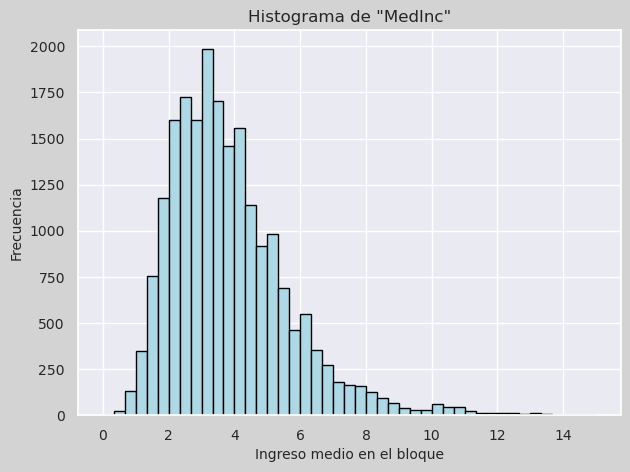

In [ ]:
plt.figure(figsize=(7, 5), facecolor='lightgrey')
df_california["MedInc"].hist(
    bins=45,
    color='white',
    edgecolor='black',
    range=(0, 15),
    facecolor = 'lightblue'
)

# Etiquetas y título
plt.xlabel('Ingreso medio en el bloque', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Histograma de "MedInc"', fontsize=12)

plt.show()

### Edad mediana de las casas en el bloque (`HouseAge`)

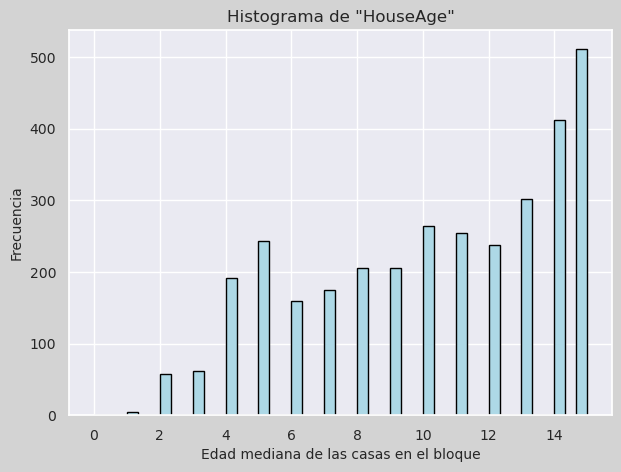

In [ ]:
plt.figure(figsize=(7, 5), facecolor='lightgrey')
df_california["HouseAge"].hist(
    bins=45,
    color='white',
    edgecolor='black',
    range=(0, 15),
    facecolor = 'lightblue'
)

# Etiquetas y título
plt.xlabel('Edad mediana de las casas en el bloque', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Histograma de "HouseAge"', fontsize=12)

plt.show()

### Número promedio de habitaciones por hogar (`AveRooms`)

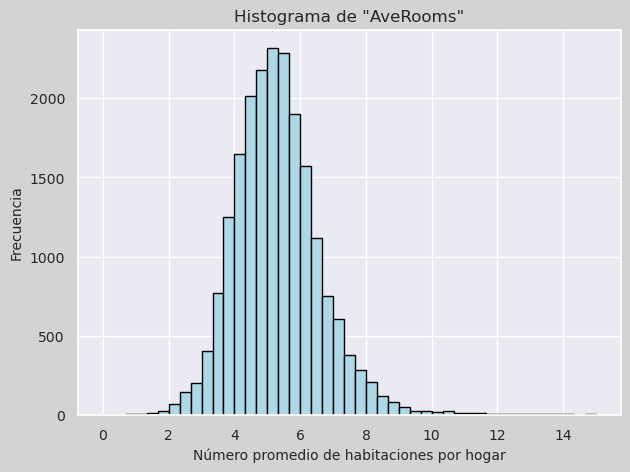

In [ ]:
plt.figure(figsize=(7, 5), facecolor='lightgrey')
df_california["AveRooms"].hist(
    bins=45,
    color='white',
    edgecolor='black',
    range=(0, 15),
    facecolor = 'lightblue'
)

# Etiquetas y título
plt.xlabel('Número promedio de habitaciones por hogar', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Histograma de "AveRooms"', fontsize=12)

plt.show()

### Número promedio de dormitorios por hogar (`AveBedrms`)

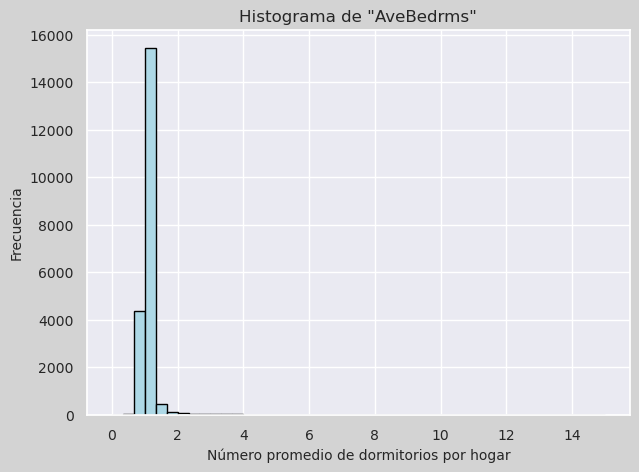

In [ ]:
plt.figure(figsize=(7, 5), facecolor='lightgrey')
df_california["AveBedrms"].hist(
    bins=45,
    color='white',
    edgecolor='black',
    range=(0, 15),
    facecolor = 'lightblue'
)

# Etiquetas y título
plt.xlabel('Número promedio de dormitorios por hogar', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Histograma de "AveBedrms"', fontsize=12)

plt.show()

### Población del bloque (`Population`)

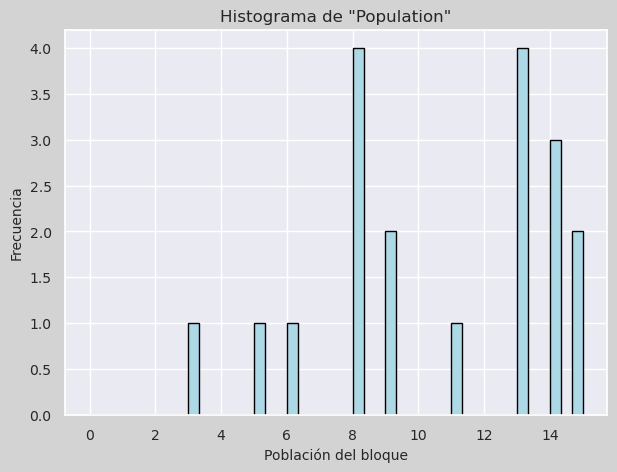

In [ ]:
plt.figure(figsize=(7, 5), facecolor='lightgrey')
df_california["Population"].hist(
    bins=45,
    color='white',
    edgecolor='black',
    range=(0, 15),
    facecolor = 'lightblue'
)

# Etiquetas y título
plt.xlabel('Población del bloque', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Histograma de "Population"', fontsize=12)

plt.show()

### Número promedio de miembros por hogar (`AveOccup`)

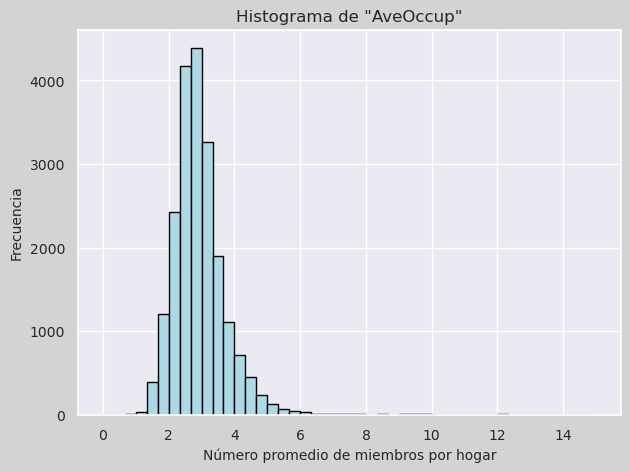

In [ ]:
plt.figure(figsize=(7, 5), facecolor='lightgrey')
df_california["AveOccup"].hist(
    bins=45,
    color='white',
    edgecolor='black',
    range=(0, 15),
    facecolor = 'lightblue'
)

# Etiquetas y título
plt.xlabel('Número promedio de miembros por hogar', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Histograma de "AveOccup"', fontsize=12)

plt.show()

### Latitud del bloque (`Latitude`)

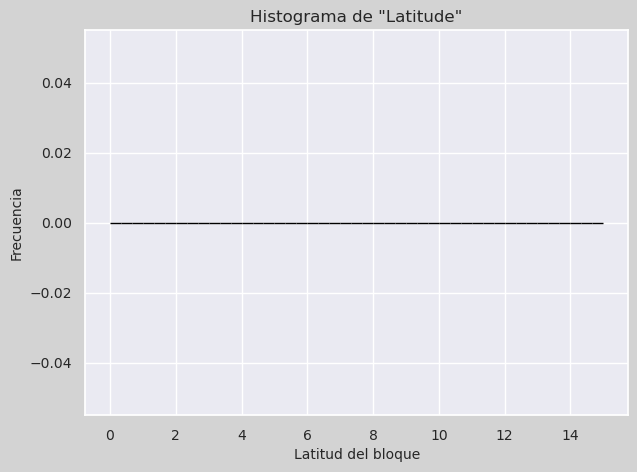

In [ ]:
plt.figure(figsize=(7, 5), facecolor='lightgrey')
df_california["Latitude"].hist(
    bins=45,
    color='white',
    edgecolor='black',
    range=(0, 15),
    facecolor = 'lightblue'
)

# Etiquetas y título
plt.xlabel('Latitud del bloque', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Histograma de "Latitude"', fontsize=12)

plt.show()

### Longitud del bloque (`Longitude`)

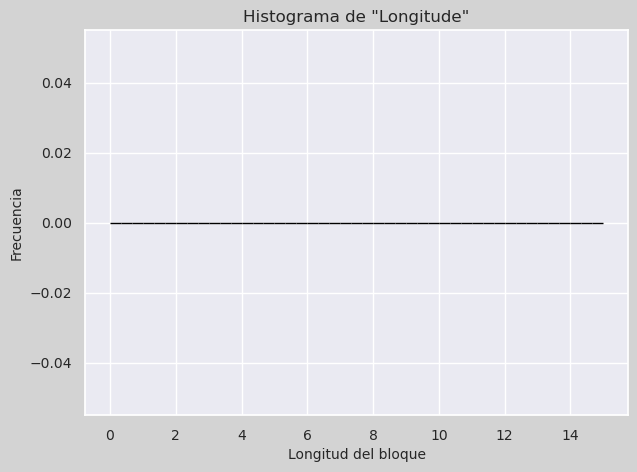

In [ ]:
plt.figure(figsize=(7, 5), facecolor='lightgrey')
df_california["Longitude"].hist(
    bins=45,
    color='white',
    edgecolor='black',
    range=(0, 15),
    facecolor = 'lightblue'
)

# Etiquetas y título
plt.xlabel('Longitud del bloque', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Histograma de "Longitude"', fontsize=12)

plt.show()

### Mediana del costo de casas en el bloque (`MedHouseVal`)

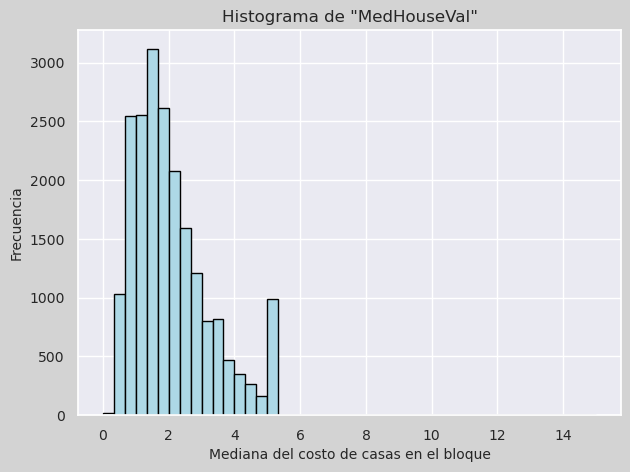

In [ ]:
plt.figure(figsize=(7, 5), facecolor='lightgrey')
df_california["MedHouseVal"].hist(
    bins=45,
    color='white',
    edgecolor='black',
    range=(0, 15),
    facecolor = 'lightblue'
)

# Etiquetas y título
plt.xlabel('Mediana del costo de casas en el bloque', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.title('Histograma de "MedHouseVal"', fontsize=12)

plt.show()

De acuerdo a las formas de los histogramas observados, se pueden ver formas similares a campanas invertidas, (lo que implicaría que siguen una distribución aproximadamente normal) las siguientes características:
* `MedInc` (aunque se observa una leve extensión a la derecha, algunas personas con mayor salario)
* `AveRooms`
* `AveOccup`

Así como tamién el target `MedHouseVal`

Por otro lado, los histogramas de `Longitude`y `Latitude`se ven como una línea horizontal, dado que son datos que tienen una concentración alta en un rango estrecho de valores.

Las otras variables no presentan la forma de distribuciones que puedan inferirse a simple vista.

## 3 - Regresión Lineal

### Separación del dataset en entrenamiento y evaluación

In [ ]:
# 70-30
X_train, X_test, y_train, y_test = train_test_split(X,  y, test_size=0.3, random_state=42)

### Escalamiento de los datos

In [ ]:
# Escalemos los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lo transformemos en DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=california_housing['feature_names'])
X_test_scaled = pd.DataFrame(X_test_scaled, columns=california_housing['feature_names'])

In [ ]:
X_train_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.133506,0.509357,0.181060,-0.273850,-0.184117,-0.010825,-0.805682,0.780934
1,-0.532218,-0.679873,-0.422630,-0.047868,-0.376191,-0.089316,-1.339473,1.245270
2,0.170990,-0.362745,0.073128,-0.242600,-0.611240,-0.044800,-0.496645,-0.277552
3,-0.402916,-1.155565,0.175848,-0.008560,-0.987495,-0.075230,1.690024,-0.706938
4,-0.299285,1.857152,-0.259598,-0.070993,0.086015,-0.066357,0.992350,-1.430902


In [ ]:
print("Media del escalador:")

i=0
for fn in california_housing['feature_names']:
    print (f"{fn} -> {scaler.mean_[i]}")
    i+=1


Media del escalador:
MedInc -> 3.8768915490033224
HouseAge -> 28.575373754152825
AveRooms -> 5.438124632178318
AveBedrms -> 1.0980331365214389
Population -> 1427.9273255813953
AveOccup -> 3.119236496102192
Latitude -> 35.650669296788486
Longitude -> -119.58410229789591


In [ ]:
print("Desvío estándar del escalador:")

i=0
for fn in california_housing['feature_names']:
    print (f"{fn} -> {np.sqrt(scaler.var_[i])}")
    i+=1


Desvío estándar del escalador:
MedInc -> 1.9048424781215183
HouseAge -> 12.613197085754871
AveRooms -> 2.453484379596035
AveBedrms -> 0.4474824960211129
Population -> 1140.1857294429738
AveOccup -> 12.373207354259023
Latitude -> 2.135668270344563
Longitude -> 2.0028608960389045


### Entrenamiento

In [ ]:
regression = LinearRegression()

regression.fit(X_train_scaled, y_train)


LinearRegression()

In [ ]:
print(f"El valor de la intersección de la recta será {regression.intercept_ }")


El valor de la intersección de la recta será 2.0692396089424165


In [ ]:
print("Los valores de los coeficientes de la recta serán:")

for coef in regression.coef_ :
    print(coef)

Los valores de los coeficientes de la recta serán:
0.8492217601003719
0.12211930906462487
-0.29955844940868714
0.34840967315636673
-0.0008844881340275348
-0.04169803877849164
-0.8938556494746313
-0.868616688061253


In [ ]:
print(f"El coeficiente de Pearson es: {regression.score(X_train_scaled, y_train)}")

El coeficiente de Pearson es: 0.6093459727972159


In [ ]:
print(f"Varianza: {np.var(y_train)}")
print(f"Desvío estándar: {np.std(y_train)}")

Varianza: 1.3396959774719193
Desvío estándar: 1.157452365098417


In [ ]:
std_dev_model = np.sqrt((np.sum((y_train - regression.predict(X_train_scaled))**2))/(y_train.size-9))
print(f"Desvío estándar del modelo: {std_dev_model}")

Desvío estándar del modelo: 0.7236600333345641


Con estos resultados se puede observar que el modelo no ajusta adecuadamente.
El ajuste lineal deja un porción importante del conjunto de datos que no se puede explicar con este modelo.

## 4 - Métricas

Calcular las métricas de MSE, MAE y R^2 del set de evaluación.

In [ ]:
#Otenemos las predicciones del modelo
y_pred = regression.predict(X_test_scaled)

def mean_porcentual_error(yreal, ypred):
    return np.mean((yreal-ypred)/yreal)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = mean_porcentual_error(y_test, y_pred)

print("R-cuadrado en test:", r2)
print("Error absoluto medio:", mae)
print("Error cuadrático medio:", mse)
print("Raiz de error cuadrático medio:", rmse)
print(f"Error absoluto porcentual medio: {mape*100:.2f}%")
print(f"Error porcentual medio: {mpe*100:.2f}%")

R-cuadrado en test: 0.5957702326061664
Error absoluto medio: 0.5272474538305955
Error cuadrático medio: 0.5305677824766752
Raiz de error cuadrático medio: 0.7284008391515452
Error absoluto porcentual medio: 31.75%
Error porcentual medio: -12.72%


## 5 - Regresión de Ridge

Crear una regresión de Ridge. Usando una validación cruzada de 5-folds y usando como métrica el MSE, calcular el mejor valor de α, buscando entre [0, 12.5]. Graficar el valor de MSE versus α

Mejor valor de alfa: 6.57
Mínimo MSE: 0.5268


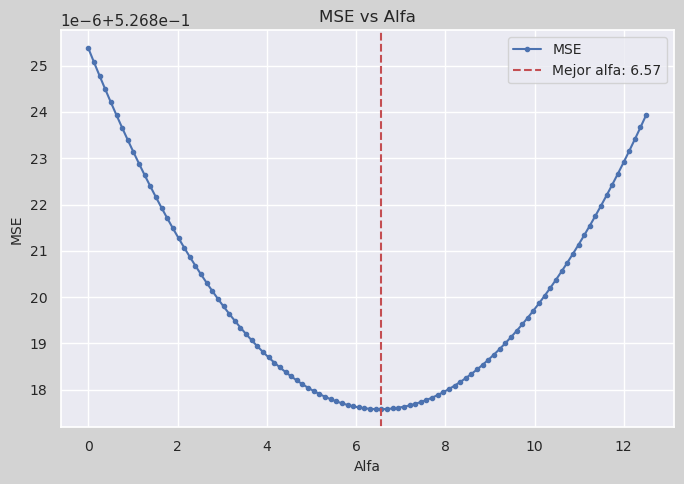

In [ ]:
# Valores de alfa entre [0, 12.5]
alpha_values = np.linspace(0, 12.5, 100)

mse_scores = np.zeros_like(alpha_values)

# Validación cruzada con Ridge para cada valor de alfa
for idx, alpha in enumerate(alpha_values):
    ridge_model = Ridge(alpha=alpha)
    # Calcular el MSE negativo promedio usando validación cruzada de 5-folds
    cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    mse_scores[idx] = (-1)*cv.mean()

# Valor de alfa que minimiza el MSE
best_alpha = alpha_values[np.argmin(mse_scores)]
min_mse = np.min(mse_scores)

print(f"Mejor valor de alfa: {best_alpha:.2f}")
print(f"Mínimo MSE: {min_mse:.4f}")

# Graficar MSE versus alfa
plt.figure(figsize=(7, 5), facecolor='lightgrey')
plt.plot(alpha_values, mse_scores, marker='.', linestyle='-', color='b', label='MSE')
plt.axvline(x=best_alpha, color='r', linestyle='--', label=f'Mejor alfa: {best_alpha:.2f}')
plt.xlabel('Alfa', fontsize=10)
plt.ylabel('MSE', fontsize=10)
plt.title('MSE vs Alfa', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(
    loc='best',
    fontsize='small'
)
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
ridge_model = Ridge(alpha=best_alpha)

ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)
mpe_ridge = mean_porcentual_error(y_test, y_pred_ridge)



results = pd.DataFrame(
    [(r2, mae, mse, rmse, mape*100, mpe*100),
    (r2_ridge, mae_ridge, mse_ridge, rmse_ridge, mape_ridge*100, mpe_ridge*100)],
    index=["Linear", "Ridge"],
    columns=["R-cuadrado en test (Pearson)", "Error absoluto medio (MAE)", "Error cuadrático medio (MSE)", "Raiz de error cuadrático medio (RMSE)", "Error absoluto porcentual medio (MAPE)", "Error porcentual medio (MPE)"])

results.head()

,R-cuadrado en test (Pearson),Error absoluto medio (MAE),Error cuadrático medio (MSE),Raiz de error cuadrático medio (RMSE),Error absoluto porcentual medio (MAPE),Error porcentual medio (MPE)
Linear,0.595770,0.527247,0.530568,0.728401,31.750266,-12.718758
Ridge,0.595887,0.527222,0.530415,0.728296,31.745897,-12.762716


## 6 - Conclusiones

No se observan mejoras significativas en los resultados obtenidos con el modelo de Ridge.

Esto puede deberse a que el modelo utiliza muchas características que no tienen alta multicolinealidad entre sí, por lo que, la regularización en este caso no sirve para disminuir significativamente la varianza.

Los datos de entrada parecen no tener buena calidad.

Pruebo a ver si es posible ajustar mejor eliminando un par de combinaciones de atributos:


### Evaluación por criterio de información de Aikake (AIC) y criterio de información bayesiano (BIC).

In [ ]:
def criterion(X, y, y_pred):
    # Agregamos uno porque hay que incorporar a la ordenada al origen
    d = X.shape[1]+1
    N = X.shape[0]

    # Calculamos los residuos al cuadrado
    residuals = y - y_pred
    Se = np.sum(residuals**2)
    # Se/N es la estimación de la varianza si los residuos provienen
    # de una normal con media cero.

    # Calculamos la estimación del logaritmo de maxima similitud de la regresión lineal
    log_lik = np.log(2*np.pi) + np.log(Se/N) + 1
    log_lik *= -N/2

    #Calculamos ambos criterios
    aic = 2*d - 2*log_lik
    bic = d*np.log(N) - 2*log_lik

    return aic, bic

In [ ]:
def train_reg_model(X, y, columns):

    # Quitamos las columnas
    X_clear = X.loc[:, columns].copy()

    model = LinearRegression()
    model.fit(X_clear, y)
    y_pred = model.predict(X_clear)

    return criterion(X_clear, y, y_pred)

In [ ]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [ ]:
regression = LinearRegression()
regression.fit(X_train_scaled, y_train)
y_pred = regression.predict(X_train_scaled)

aic0, bic0 = criterion(X_train_scaled, y_train, y_pred)

print(f"AIC inicial es {np.round(aic0)}")
print(f"BIC inicial es {np.round(bic0)}")

AIC inicial es 31665.0
BIC inicial es 31733.0


In [ ]:
print(X_train_scaled.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')


In [ ]:
#Escenarios de 7 y 6 atributos

data = [
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'Latitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude'],
    ['MedInc', 'HouseAge', 'AveBedrms', 'Population', 'AveOccup', 'Latitude'],
    ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveBedrms', 'Population', 'AveOccup', 'Longitude'],
    ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveBedrms', 'Population', 'Latitude', 'Longitude'],
    ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'HouseAge', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude'],
    ['MedInc', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']]

print(len(data))

32


In [ ]:
# Itero buscando si alguno de los escenarios mejora los resultados

i = 0
best_aic = 0
best_bic = 0
indexx = [0]*(len(data))
valuex = [0]*(len(data))
for datax in data:
    aic, bic = train_reg_model(X_train_scaled, y_train, datax)
    indexx[i] = datax
    valuex[i] = (aic, bic)
    if aic <= aic0:
        aic0 = aic
        best_aic=i
    if bic <= bic0:
        bic0 = bic
        best_bic=i
    i+=1

print (f"{best_aic}-{best_bic}")


4-4


In [ ]:
print(f"Mejor AIC/BIC con: {indexx[best_aic]}")

Mejor AIC/BIC con: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'AveOccup', 'Latitude', 'Longitude']


In [ ]:
X_train_scaled.head()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,0.133506,0.509357,0.181060,-0.273850,-0.184117,-0.010825,-0.805682,0.780934
1,-0.532218,-0.679873,-0.422630,-0.047868,-0.376191,-0.089316,-1.339473,1.245270
2,0.170990,-0.362745,0.073128,-0.242600,-0.611240,-0.044800,-0.496645,-0.277552
3,-0.402916,-1.155565,0.175848,-0.008560,-0.987495,-0.075230,1.690024,-0.706938
4,-0.299285,1.857152,-0.259598,-0.070993,0.086015,-0.066357,0.992350,-1.430902


In [ ]:
X_test_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,-1.152689,-0.283463,-0.507818,-0.169278,-0.031510,0.061278,0.191664,0.286641
1,-0.706406,0.112947,-0.162520,0.213327,0.120220,-0.035516,-0.239115,0.061963
2,-0.208307,1.857152,-0.595467,0.196308,-0.103428,-0.142154,1.006397,-1.425909
3,0.976831,-0.917719,0.295707,-0.173931,0.243007,0.026283,-0.641799,0.431434
4,-0.079740,0.430075,0.022362,-0.156421,-0.320060,-0.051368,0.453877,-1.171273


In [ ]:
c = set(X_train_scaled.columns)

set_array_strings = set(indexx[best_aic])
deletec = c - set_array_strings

print(f"Columnas a eliminar: {deletec}")


Columnas a eliminar: {'Population'}


In [ ]:
for c in deletec:
    X_train_scaled = X_train_scaled.drop(c, axis=1)
    X_test_scaled = X_test_scaled.drop(c, axis=1)


In [ ]:
X_train_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,AveOccup,Latitude,Longitude
0,0.133506,0.509357,0.181060,-0.273850,-0.010825,-0.805682,0.780934
1,-0.532218,-0.679873,-0.422630,-0.047868,-0.089316,-1.339473,1.245270
2,0.170990,-0.362745,0.073128,-0.242600,-0.044800,-0.496645,-0.277552
3,-0.402916,-1.155565,0.175848,-0.008560,-0.075230,1.690024,-0.706938
4,-0.299285,1.857152,-0.259598,-0.070993,-0.066357,0.992350,-1.430902


In [ ]:
X_test_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,AveOccup,Latitude,Longitude
0,-1.152689,-0.283463,-0.507818,-0.169278,0.061278,0.191664,0.286641
1,-0.706406,0.112947,-0.162520,0.213327,-0.035516,-0.239115,0.061963
2,-0.208307,1.857152,-0.595467,0.196308,-0.142154,1.006397,-1.425909
3,0.976831,-0.917719,0.295707,-0.173931,0.026283,-0.641799,0.431434
4,-0.079740,0.430075,0.022362,-0.156421,-0.051368,0.453877,-1.171273


In [ ]:
regression = LinearRegression()
regression.fit(X_train_scaled, y_train)

y_pred = regression.predict(X_test_scaled)

r2 = r2_score(y_test, y_pred)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
mpe = mean_porcentual_error(y_test, y_pred)


In [ ]:
# Valores de alfa entre [0, 12.5]
alpha_values = np.linspace(0, 12.5, 100)

mse_scores = np.zeros_like(alpha_values)

# Validación cruzada con Ridge para cada valor de alfa
for idx, alpha in enumerate(alpha_values):
    ridge_model = Ridge(alpha=alpha)
    # Calcular el MSE negativo promedio usando validación cruzada de 5-folds
    cv = cross_val_score(ridge_model, X_train_scaled, y=y_train, scoring="neg_mean_squared_error", cv=5, n_jobs=-1)
    mse_scores[idx] = (-1)*cv.mean()

# Valor de alfa que minimiza el MSE
best_alpha = alpha_values[np.argmin(mse_scores)]
min_mse = np.min(mse_scores)

print(f"Mejor valor de alfa: {best_alpha:.2f}")
print(f"Mínimo MSE: {min_mse:.4f}")

idge_model = Ridge(alpha=best_alpha)

ridge_model.fit(X_train_scaled, y_train)

y_pred_ridge = ridge_model.predict(X_test_scaled)

r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)
mpe_ridge = mean_porcentual_error(y_test, y_pred_ridge)



results = pd.DataFrame(
    [(r2, mae, mse, rmse, mape*100, mpe*100),
    (r2_ridge, mae_ridge, mse_ridge, rmse_ridge, mape_ridge*100, mpe_ridge*100)],
    index=["Linear", "Ridge"],
    columns=["R-cuadrado en test (Pearson)", "Error absoluto medio (MAE)", "Error cuadrático medio (MSE)", "Raiz de error cuadrático medio (RMSE)", "Error absoluto porcentual medio (MAPE)", "Error porcentual medio (MPE)"])

results.head()


Mejor valor de alfa: 6.94
Mínimo MSE: 0.5267


,R-cuadrado en test (Pearson),Error absoluto medio (MAE),Error cuadrático medio (MSE),Raiz de error cuadrático medio (RMSE),Error absoluto porcentual medio (MAPE),Error porcentual medio (MPE)
Linear,0.595754,0.527256,0.530590,0.728416,31.749803,-12.717425
Ridge,0.595975,0.527214,0.530299,0.728217,31.742579,-12.801271


Tampoco se obtienen mejoras significativas, por lo que, concluyo que este set de datos requiere la exploración de modelos más complejos, no se ajusta a un modelo lineal.
